# Welcome to the Notebook for Monha's and Bemi's Bachelor Project

## Content

In this notebook we will:

1. Aggrigate our data into usable travel sequences with only the relevant data 
2. Analyse the appropriate data
3. Create an embedding space using Word2Vec

We will use the following format for the structure of the file:
1. MD file to describe the intention of the following code followed by an explanation of the results from the code if any
2. Code block to write code

# Initial Setup

Please pip install the correct libraries for the following code to work.

In [ ]:
%pip install pandas # Pandas for data handling
%pip install numpy  # Maths stuff

In [1]:
import pandas as pd
import numpy as np
import re


# Data import

The data used in this notebook is extracted from the Journeys table from the DB. 

The data in question contains ~43 mil rows. This data is all journeys traveled in the timespan of ~4 years. For the purpose of this project we wish to filter the data, such that we only work with journeys within Copenhagen.

In [ ]:
data = pd.read_csv('../Data/All_Journeys.csv')
data.count()

## Filtering data

In order to filter our data, XXX checks need to be made to be certain a journey is within cph as well as containing information relevant for our purpose. 

For a journey to be within cph they need to only make use of zone 1 through 4
1. Check if *internalStartZones* only contain zones within cph
2. Check if *internalValidZones* only contain zones within cph

For a journey to be relevant for the project, we need the fields *StartStop*, *EndStop*, *SearchStart* and *SearchEnd* to be either fully filled out or partly - that is, if Start- and EndStop are null, then SearchStart and -End need to be filled. Likewise, the fields must not match in their values; a journeys start and end should not be the same.


In [ ]:
#Copenhagen filtering
condition_1_cph = (
    (data['internalValidZones'].str.match(r'^(1001|1002|1003|1004)(,(1001|1002|1003|1004))*$')
    | # or
    pd.isna(data['internalValidZones']))
    )

condition_2_cph = (
    (data['internalStartZones'].str.match(r'^(1001|1002|1003|1004)$'))
    | # or
    pd.isna(data['internalStartZones'])
    )

In [ ]:
cph_data = data[(condition_1_cph)]
cph_data = cph_data[(condition_2_cph)]

cph_data = cph_data[ ~ (cph_data['SearchStart'].str.contains("okation", na=False)
                                             | #Or
                                             cph_data['SearchStart'].str.contains("zoner", na=False))]

cph_data = cph_data[( ~ (cph_data['SearchEnd'].str.contains("zoner", na=False) 
                                            | #Or
                                            cph_data['SearchEnd'].str.contains("okation", na=False)))]

# next two filters are English filters of the first
cph_data = cph_data[( ~ (cph_data['SearchEnd'].str.contains("zones", na=False) 
                                            | #Or
                                            cph_data['SearchEnd'].str.contains("ocation", na=False)))]

cph_data = cph_data[( ~ (cph_data['SearchStart'].str.contains("zones", na=False) 
                                            | #Or
                                            cph_data['SearchStart'].str.contains("ocation", na=False)))]

# Next filter is to remove entries where one of the matching search-x or x-stop are Null
cph_data = cph_data[(
                                        ( ~ (pd.isna(cph_data['SearchStart'])) & ~ (pd.isna(cph_data['SearchEnd'])))
                                        | # Or
                                        ( ~ (pd.isna(cph_data['StartStop'])) & ~ (pd.isna(cph_data['EndStop'])))
                                        )]

# Next filter removes all entries where SearchStart and SearchEnd contain the same value
cph_data = cph_data[(
                        ~(cph_data['SearchStart'] == cph_data['SearchEnd'])
                        )]

cph_data

## Testing to see whether our filtering worked

Since we are handling a very large amount of data, it can be difficult to scim through the data in order to see if it is as intended. These tests are used in order to detect whether or not rows that are not supposed to be in our data is in our data.

In [ ]:
# Test 1 for whether our data contain seachEnd with contains 'lokation' or 'location'
lokation_count = cph_data[cph_data['SearchEnd'].str.contains("okation", na=False)].count()
print(f"Amount of 'Lokation' entires in 'SearchEnd' : {lokation_count['SearchEnd']}")

location_count = cph_data[cph_data['SearchEnd'].str.contains("ocation", na=False)].count()
print(f"Amount of 'Location' entires in 'SearchEnd' : {lokation_count['SearchEnd']}")

# Test 2 for whether our data contain seachStart with contains 'lokation' or 'location'
lokation_count_s = cph_data[cph_data['SearchStart'].str.contains("okation", na=False)].count()
print(f"Amount of 'Lokation' entires in 'SearchStart' : {lokation_count_s['SearchStart']}")

location_count_s = cph_data[cph_data['SearchStart'].str.contains("ocation", na=False)].count()
print(f"Amount of 'Location' entires in 'SearchStart' : {location_count_s['SearchStart']}")

# Test 3 for whether our data contain SearchStart with 'zones' or 'zoner'
zones_count = cph_data[cph_data['SearchEnd'].str.contains("zones", na=False)].count()
print(f"Amount of 'zones' entires in 'SearchEnd' : {zones_count['SearchEnd']}")

zones_count_r = cph_data[cph_data['SearchEnd'].str.contains("zoner", na=False)].count()
print(f"Amount of 'zoner' entires in 'SearchEnd' : {zones_count_r['SearchEnd']}")

# Test 4 for whether our data contain None in 3 or more fields (startStop, EndStop, SearchStart and SearchEnd)
num_nulls = cph_data[['StartStop', 'EndStop', 'SearchStart', 'SearchEnd']].isna().sum(axis=1)
b = (num_nulls >= 3).any()
print(f"Does the data contain a row which 3 of StartStop, EndStop, SearchStart or SearchEnd is null: {b}")

# Test 5 for whether our data contain duplicates in matching fields, i.e. StartStop == EndStop
duplicates_in_stop = cph_data[(cph_data['StartStop'] == cph_data['EndStop'])].count()
print(f"Amount of matching values in StartStop and EndStop : {duplicates_in_stop['StartStop']}")


# Test 6 for whether our data contain duplicates in matching fields, i.e. SearchStart == SearchEnd
duplicates_in_stop = cph_data[(cph_data['SearchStart'] == cph_data['SearchEnd'])].count()
print(f"Amount of matching values in SearchStart and SearchEnd : {duplicates_in_stop['SearchStart']}")

# Test 7 for whether our data contain three of the fields filled.
num_filled = ~(cph_data[['StartStop', 'EndStop', 'SearchStart', 'SearchEnd']].isna()).sum(axis=1)
b = (num_filled == 3).any()
print(f"Does the data contain a row which 3 of StartStop, EndStop, SearchStart or SearchEnd are filled: {b}")


# Sequences

We now wish to make sequences from the journeys. The sequnces should either be a value pair of SearchStart and Searchend or a pair of StartStop and EndStop. To do this we simply collect the pairs from the dataframe where StartStop and EndStop Id's are "translated" to station names. 

When making the sequences, certain questions arrise about the data. For instance, of the 3,4 mil datapoints, only 64 of the datapoints contain a value *only* in StartStop and EndStop. (```python test_df[~(pd.isna(test_df['StartStop'])) & (pd.isna(test_df['SearchStart']))]```)

Another important decision is deciding on how to extract stations from SearchStart and SearchEnd, since a lot of the entries does not consist of a directly matching station. i.e. 'Hovedebanegården' being the SearchStart for the station 'København H'. Thus we need to match these inconsistent strings with a consistent naming convention. 

The first step in the creation of sequences is to prase our strings to fit the same format. A bunch of stations have '(01)' or another number in the parenthesis, probably incidating either which zones the user is searching from or where they are going. We are not interested in this number. The following regex will handle this parsing:

```regex 
    r'[(]\d\d[)]'
```

Likewise we are not interested in detailed searches like a full address; Klokkerhøjen 6 st, 2400 København NV, Denmark. Thus we wish to remove all symbols after ','. We do this with the following regex:

```regex
    r'(,.*$)'
```

(THIS ONE ALSO REPLACES THE FIRST REGEX)
Lastly we wish to remove all '(togbus)' parts of a string. Here we do note, that the strings might contain '(metro)' which we are interested in keeping. Thus we need to remove all symbols inside a parenthesis but not if the symbols are the string 'metro'. This will be done partly through code and partly with the regex:

```regex
    r'\s*\([^)]*\)'
```



In [2]:
cph_data = pd.read_csv('..//Database Analysis/cph_file.csv')

In [3]:
pattern_for_comma = r'(,.*$)'
pattern_for_parenthesis = r'\s*\([^)]*\)'
pattern_for_parenthesis_number = r'[(]\d\d[)]'

sequences = []

station_counter = {}

def get_sequence(row) -> None:
    initial_start   = row['SearchStart']
    initial_end     = row['SearchEnd']
    if pd.notna(initial_start):
        start   = re.sub(pattern_for_comma, "", initial_start)
        end     = re.sub(pattern_for_comma, "", initial_end)

        if "Metro" not in start:
            start   = re.sub(pattern_for_parenthesis, "", start)
        else: 
            start   = re.sub(pattern_for_parenthesis_number, "", start)
                
        if "Metro" not in end:
            end   = re.sub(pattern_for_parenthesis, "", end)
        else:
            end   = re.sub(pattern_for_parenthesis_number, "", end)
        
        if start.strip() != "":
            sequences.append([start.strip(), end.strip()])
            
            start = start.strip()
            end = end.strip()
            
            if start not in station_counter:
                station_counter[start] = 1
            else:
                station_counter[start] = station_counter[start] + 1
            
            if end not in station_counter:
                station_counter[end] = 1
            else:
                station_counter[end] = station_counter[end] + 1
        
cph_data.apply(get_sequence, axis=1)

0          None
1          None
2          None
3          None
4          None
           ... 
3471258    None
3471259    None
3471260    None
3471261    None
3471262    None
Length: 3471263, dtype: object

In [ ]:
res = dict(sorted(station_counter.items(), key = lambda x: x[1], reverse = True)[:10])
res

# Top used stations are:
# 'København H': 402727,
# 'Nørreport St.': 342289,
# 'Kongens Nytorv St. (Metro)': 326808,
# 'CPH Lufthavn': 235769,
# 'Refshaleøen': 189228,
# 'Hovedbanegården': 156454,
# 'Ørestad St.': 139841,
# 'København H (Metro)': 115016,
# 'Christianshavn St. (Metro)': 106272,
# 'Amagerbro St. (Metro)': 101808


In [ ]:

for station in station_counter.keys():
    if station.__contains__("Kongens Nytorv"):
        print(f"{station} : {station_counter[station]}")

## Dealing with the problem of the same places in Copenhagen being searched with different naming conventions (and languages)

In [ ]:
%pip install geopy


In [5]:
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
geolocator = Nominatim(user_agent="my_geocoder")

- geopy is a Python client for several popular geocoding web services.

- geopy makes it easy for Python developers to locate the coordinates of addresses, cities, countries, and landmarks across the globe using third-party geocoders and other data sources.

- geopy includes geocoder classes for the OpenStreetMap Nominatim, Google Geocoding API (V3), and many other geocoding services. The full list is available on the Geocoders doc section. Geocoder classes are located in geopy.geocoders.

A small test testing some random stations in Copenhagen

In [ ]:



# Top used stations are:
# 'København H': 402727,
# 'Nørreport St.': 342289,
# 'Kongens Nytorv St. (Metro)': 326808,
# 'CPH Lufthavn': 235769,
# 'Refshaleøen': 189228,
# 'Hovedbanegården': 156454,
# 'Ørestad St.': 139841,
# 'København H (Metro)': 115016,
# 'Christianshavn St. (Metro)': 106272,
# 'Amagerbro St. (Metro)': 101808


place1 = 'København H'  # 55.6727587 12.564678938785772
place2 = 'Nørreport St.' #55.6840689 12.5725383
# place3 = 'Kongens Nytorv St. (Metro)'
place4 = 'CPH Lufthavn' #55.6091282 12.650982248393536
place5 = 'Refshaleøen' #55.693321499999996 12.61966813806588
place6 = 'Hovedbanegården' #55.6727587 12.564678938785772
place7 = 'Ørestad St.' # 55.6727587 12.564678938785772
# place8 = 'København H (Metro)'
# place9 = 'Christianshavn St. (Metro)'
# place10 = 'Amagerbro St. (Metro)'

location_place1 = geolocator.geocode(place1)
location_place2 = geolocator.geocode(place2)
# location_place3 = geolocator.geocode(place3)
location_place4 = geolocator.geocode(place4)
location_place5 = geolocator.geocode(place5)
location_place6 = geolocator.geocode(place6)
# location_place8 = geolocator.geocode(place8)
# location_place9 = geolocator.geocode(place9)
# location_place10 = geolocator.geocode(place10)

print("Location 1:", location_place1.latitude, location_place1.longitude)
print("Location 2:", location_place2.latitude, location_place2.longitude)
# print("Location 3:", location_place3.latitude, location_place3.longitude)
print("Location 4:", location_place4.latitude, location_place4.longitude)
print("Location 5:", location_place5.latitude, location_place5.longitude)
print("Location 6:", location_place6.latitude, location_place6.longitude)
print("Location 7:", location_place6.latitude, location_place6.longitude)
# print("Location 8:", location_place8.latitude, location_place8.longitude)
# print("Location 9:", location_place9.latitude, location_place9.longitude)
# print("Location 10:", location_place10.latitude, location_place10.longitude)

In [6]:
from geopy.distance import geodesic
from geopy.exc import GeocoderTimedOut
from geopy.exc import GeocoderUnavailable
from geopy.exc import GeocoderQueryError
import time

location_to_coordinate = {}
def add_coordinate_to_station(station):    
    retries = 3
    while retries > 0:
        try: 
            if station.__contains__("Metro"):
                station_metro = str.replace(station, "(Metro)", "").strip()
                coord = geolocator.geocode(station_metro)
            else:    
                coord = geolocator.geocode(station)    
                
            location_to_coordinate[station] = coord
            break  # Exit the retry loop if successful
        except GeocoderTimedOut as e:
            retries -= 1
            if retries == 0:
                print(f" Max retries exceeded for {station}. Skipping...")
            time.sleep(1)  # Add a delay between retries to avoid overwhelming the server
        except GeocoderUnavailable as e:
            print(f"Geocoder unavailable: {e}")
            time.sleep(5)  # Wait for 5 seconds before retrying
        except GeocoderQueryError as e:
            print(f"Geocoder query error: {e}")
            break  # Exit the retr  y loop if there's a query error


#### A first tester to find all stations in the sequences that match around the coordinates of 'Hovedbanegården'
The targets we want that are known to us is specifically 'København H' / 'Hovedbanegården' and 'Cph lufthavn'/ 'Kbh lufthavnen' /'Lufthavnen st'/ 'Kastrup st'

Trying to create a list of unique stationnames to use with the geolocator to save time. 

In [4]:
distinct_stations_set = set()
for seq in sequences:
    for place in seq:
        distinct_stations_set.add(place)

# Convert the set back to a list
unique_stations_list = list(distinct_stations_set)
print(unique_stations_list)
len(unique_stations_list)


['Aggersvoldvej 10', 'Nyropsgade 28', 'Hedebygade 9A', 'Valmuevej 34', 'Amager Landevej 49', 'Tirstrupvej 4', 'Erik Husfeldts Vej', 'Saltværksvej 163', 'Staldgade 1699 København V', 'Solvænget 3', 'Lyngbyvej 59', 'Luftmarinegade 1', 'Hellerupvej 6', 'Grønjordskollegiet 2300 København S', 'Strandboulevarden 33', 'Ebertsgade 2', 'Oliebladsgade 1', 'Classensgade 60', 'Rubinsteinsvej 41', 'Gammel Kongevej 107', 'Under Elmene 18', 'Tjærebyvej 2700 Brønshøj', 'Tycho Brahes Allé 46', 'Teglholmens Østkaj 86', 'Gustav Johannsens Vej 2000 Frederiksberg', 'Tuborgvej 258', 'Knudsbølvej 76', 'Isafjordsgade 14', 'Finsensvej 50B', 'C.F. Richs Vej 80', 'Kongelundsvej 94N', 'Jernbane Allé 55', "Preben Kaas' Vænge 1", 'Tietgenkollegiet', 'Morsøvej 26', 'Ålekistevej 42', 'Fanny Jensens Plads 2450 København SV', 'Vinkelager 23', 'Engvej 113', 'Rentemestervej 34', 'Holmbladsgade 38', 'Jægersborggade 9', 'Nytorv 3C', 'Istedgade 42', 'Mikkel Bryggers Gade 7', 'Vestergade 2D', 'Psyak 11', 'Ryparken 204', 'Ske

40602

In [8]:
count = 0
for station in distinct_stations_set:
    add_coordinate_to_station(station)
    count += 1
    if count == 20000:
        print("Halfway!")

 Max retries exceeded for Ydunsgade 2200 København N. Skipping...
 Max retries exceeded for Finlandsgade 2300 København S. Skipping...
 Max retries exceeded for Hangar 1 Vej 2770 Kastrup. Skipping...
 Max retries exceeded for Østrigsgade 2300 København S. Skipping...
 Max retries exceeded for Siljangade 2300 København S. Skipping...
 Max retries exceeded for Tejn Alle 2. Skipping...
 Max retries exceeded for Strandvejen 97. Skipping...
 Max retries exceeded for Philip De Langes Allé 1435 København K. Skipping...
 Max retries exceeded for Tietgensgade 35-39. Skipping...
 Max retries exceeded for Nikolaj Plads 1067 København K. Skipping...
 Max retries exceeded for Strandvejen 22B. Skipping...
 Max retries exceeded for Sigbrits Allé 8. Skipping...
 Max retries exceeded for Elme Alle 9. Skipping...
 Max retries exceeded for Molestien 2450 København SV. Skipping...
 Max retries exceeded for Sorrentovej 2300 København S. Skipping...
 Max retries exceeded for Islands Brygge 32A. Skipping...


In [57]:
location_to_coordinate['København H']

40515

In [39]:
import json
from geopy.location import Location
def location_encoder(obj):
    if isinstance(obj, Location):
        return {
                "latitude"  : obj.latitude, 
                "longitude" : obj.longitude,
                "address"   : obj.address,
                "raw"       : obj.raw
                }
    return obj



#Store the dict as JSON
with open("data.json", "w") as file:
    json.dump(location_to_coordinate, file, default=location_encoder, indent=4)



In [60]:
# def location_decoder(dct):
#     print (dct)
#     # Check if the dictionary contains the expected keys
#     if "latitude" in dct and "longitude" in dct and "address" in dct and "raw" in dct:
#         # Extract data from the dictionary
#         latitude = dct["latitude"]
#         longitude = dct["longitude"]
#         address = dct["address"]
#         raw = dct["raw"]
        
#         # Construct a Location object
#         location = Location(latitude=latitude, longitude=longitude, address=address, raw=raw)
        
#         # Return a tuple with the key and the Location object
#         return (address.split(',')[0].strip(), location)
#     else:
#         # If one or more keys are missing, return None or handle the error as appropriate
#         return None
    
    
#Read file and access by [key][latitude/longitude/address/raw]
with open("data.json", "r") as file:
    loaded_data = json.load(file)
    
loaded_data['København H']

{'latitude': 55.6727587,
 'longitude': 12.564678938785772,
 'address': 'Københavns Hovedbanegård, Bernstorffsgade, Postbyen, Kødbyen, København, Københavns Kommune, Indre By, Region Hovedstaden, 1570, Danmark',
 'raw': {'place_id': 130594297,
  'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright',
  'osm_type': 'way',
  'osm_id': 91260821,
  'lat': '55.6727587',
  'lon': '12.564678938785772',
  'class': 'building',
  'type': 'train_station',
  'place_rank': 30,
  'importance': 0.4446018493465384,
  'addresstype': 'building',
  'name': 'Københavns Hovedbanegård',
  'display_name': 'Københavns Hovedbanegård, Bernstorffsgade, Postbyen, Kødbyen, København, Københavns Kommune, Indre By, Region Hovedstaden, 1570, Danmark',
  'boundingbox': ['55.6718619', '55.6736548', '12.5635277', '12.5669246']}}

In [ ]:
from geopy.distance import geodesic
from geopy.exc import GeocoderTimedOut
from geopy.exc import GeocoderUnavailable
from geopy.exc import GeocoderQueryError
import time
# List to store places close to the target coordinates

#should return a list of all locations that should be mapped to the target coordinations station
def get_locations_close_to_target(targetCoords, unique_stations):
    iteration_counter = 0
    places_close_to_target = []
    # Iterate through the sequences and their elements
    for place in unique_stations:
        
        if "Metro" in place:
            continue
        
        iteration_counter += 1
        # Check if the place already exists in places_close_to_target
        if any(place == p for p in places_close_to_target):
            continue  # Skip this place if it already exists in places_close_to_target

        retries = 3
        while retries > 0:
            try:
                location = geolocator.geocode(place, timeout=None)
                if location is not None:
                    place_coordinates = (location.latitude, location.longitude)
                    distance_to_target = geodesic(targetCoords, place_coordinates).kilometers
                    if distance_to_target < 0.1:  # Adjust this threshold as needed
                        places_close_to_target.append(place)  # Append place name only
                        unique_stations.remove(place)
                        print(f"location number in list: {iteration_counter}")
                break  # Exit the retry loop if successful
            except GeocoderTimedOut as e:
                retries -= 1
                if retries == 0:
                    print(f" Max retries exceeded for {place}. Skipping...")
                time.sleep(1)  # Add a delay between retries to avoid overwhelming the server
            except GeocoderUnavailable as e:
                print(f"Geocoder unavailable: {e}")
                time.sleep(5)  # Wait for 5 seconds before retrying
            except GeocoderQueryError as e:
                print(f"Geocoder query error: {e}")
                break  # Exit the retr  y loop if there's a query error

    return places_close_to_target, unique_stations


In [ ]:

København_H  =    (55.6727587, 12.564678938785772)
Nørreport_St =    (55.6840689, 12.5725383)
CPH_Lufthavn =    (55.6091282, 12.650982248393536)
Refshaleøen  =    (55.693321499999996, 12.61966813806588)
# Hovedbanegården = (55.6727587, 12.564678938785772)

all_stations_to_change_kbh_h, updated_list           = get_locations_close_to_target(København_H, unique_stations_list)
all_stations_to_change_nørreport, updated_list       = get_locations_close_to_target(Nørreport_St, updated_list)
all_stations_to_change_cph_lufthavn, updated_list    = get_locations_close_to_target(CPH_Lufthavn, unique_stations_list)
all_stations_to_change_refshaleøen , updated_list    = get_locations_close_to_target(Refshaleøen, updated_list)

# lufthavnen_coords = (55.595098, 12.6179894)
# hovedbanen_coords = (55.595098, 12.6179894)
# lufthavnen = get_locations_close_to_target(lufthavnen_coords,unique_stations_list)
# hovedbanen = get_locations_close_to_target(hovedbanen_coords,unique_stations_list)

For each sequence check if the name is in the list of locations that should be interpreted as 'København H' and replace these with København H

In [ ]:
# Iterate through the sequences
for i, sequence in enumerate(sequences):
    station1, station2 = sequence
    # Check if the first station matches any place close to København H
    for place, distance in places_close_to_target:
        if station1 == place:
            sequences[i][0] = 'København H'
    # Check if the second station matches any place close to København H
    for place, distance in places_close_to_target:
        if station2 == place:
            sequences[i][1] = 'København H'

# Print the updated sequences
print("Updated sequences:")
for sequence in sequences:
    print(sequence)


In [5]:
#following code runs twice but should not be a problem.
for seq in sequences:
    for p in seq:
        if not seq[0].__contains__("Metro"):
            if seq[0].__contains__("Hovedbane"):
                seq[0] = "København H"
            elif seq[0].__contains__("Lufthavn"):
                seq[0] = "CPH Lufthavn"
        
        if not seq[1].__contains__("Metro"):
            if seq[1].__contains__("Hovedbane"):
                seq[1] = "København H"
            elif seq[0].__contains__("Lufthavn"):
                seq[0] = "CPH Lufthavn"

In [2]:
import csv

with open('sequences.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(sequences)

In [6]:
temp = sequences

In [9]:
pattern = r'\d.*'


for location in temp:
    location[0] = (re.sub(pattern, '', location[0])).strip()
    if location[0] == '':
        temp.remove(location)
        continue 
    if location[0][-1] == '(':
        location[0] = location[0][:-1]
    if location[0] == 'Zoo':
        location[0] = "Zoologisk Have"

    
    location[1] = (re.sub(pattern, '', location[1])).strip()
    if location[1] == '':
        temp.remove(location)
        continue
    if location[1][-1] == '(':
        location[1] = location[1][:-1]
    if location[1] == 'Zoo':
        location[1] = "Zoologisk Have"

    
temp

[['København H', 'Borrebyvej'],
 ['København H', 'Hulgårds Plads'],
 ['København H', 'Islands Brygge St. (Metro)'],
 ['København H (Metro)', 'Frederiksberg Allé St. (Metro)'],
 ['Nørreport St.', 'Sluseholmen'],
 ['Lufthavnen St. (Metro)', 'Aksel Møllers Have St. (Metro)'],
 ['CPH Lufthavn', 'Istedgade'],
 ['Ryumgårdsvej', 'Dybbølsbro St.'],
 ['Teglgårdstræde', 'Kapelvej'],
 ['Nørreport St.', 'Forum St. (Metro)'],
 ['Drechselsgade', 'København H'],
 ['Nyhavn', 'Refshaleøen'],
 ['Nørre Campus', 'Dronningens Tværgade'],
 ['Elmegade', 'København H'],
 ['Værnedamsvej', 'Skellet'],
 ['Elmegade', 'Vestamager St. (Metro)'],
 ['Fisketorvet', 'Sjælør St.'],
 ['Dybbølsbro St.', 'Østerport St.'],
 ['Orientkaj St.', 'Østerport St.'],
 ['Sønderport', 'Rådhuspladsen St. (Metro)'],
 ['Vesterport St.', 'København H'],
 ['København H', 'Nordhavn St.'],
 ['CPH Lufthavn', 'Nordhavn St.'],
 ['Terminalvej', 'Hellerup St.'],
 ['Polititorvet', 'Amager Boulevard'],
 ['Nordre Toldbod', 'Refshaleøen'],
 ['Forum 

In [10]:
def has_numbers(inputString):
    return any(char.isdigit() for char in inputString)

for location in temp:
    if has_numbers(location[0]):
        print(location[0])
    if has_numbers(location[1]):
        print(location[1])
        

In [35]:
import csv

with open('../sequences.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(temp)

In [34]:
with open('../Data/sequence_list.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(temp)

In [11]:
def flatten_list(lst):
    flattened = []
    for item in lst:
        if isinstance(item, list):
            flattened.extend(flatten_list(item))
        else:
            flattened.append(item)
    return flattened

temp_flat = flatten_list(temp)
temp_flat


['København H',
 'Borrebyvej',
 'København H',
 'Hulgårds Plads',
 'København H',
 'Islands Brygge St. (Metro)',
 'København H (Metro)',
 'Frederiksberg Allé St. (Metro)',
 'Nørreport St.',
 'Sluseholmen',
 'Lufthavnen St. (Metro)',
 'Aksel Møllers Have St. (Metro)',
 'CPH Lufthavn',
 'Istedgade',
 'Ryumgårdsvej',
 'Dybbølsbro St.',
 'Teglgårdstræde',
 'Kapelvej',
 'Nørreport St.',
 'Forum St. (Metro)',
 'Drechselsgade',
 'København H',
 'Nyhavn',
 'Refshaleøen',
 'Nørre Campus',
 'Dronningens Tværgade',
 'Elmegade',
 'København H',
 'Værnedamsvej',
 'Skellet',
 'Elmegade',
 'Vestamager St. (Metro)',
 'Fisketorvet',
 'Sjælør St.',
 'Dybbølsbro St.',
 'Østerport St.',
 'Orientkaj St.',
 'Østerport St.',
 'Sønderport',
 'Rådhuspladsen St. (Metro)',
 'Vesterport St.',
 'København H',
 'København H',
 'Nordhavn St.',
 'CPH Lufthavn',
 'Nordhavn St.',
 'Terminalvej',
 'Hellerup St.',
 'Polititorvet',
 'Amager Boulevard',
 'Nordre Toldbod',
 'Refshaleøen',
 'Forum St.',
 'Bremensgade',
 'Gam

In [12]:
station_counter= {}
for location in temp_flat:
    if location not in station_counter:
        station_counter[location] = 1
    else:
        station_counter[location] = station_counter[location] + 1
station_counter

stations = list(station_counter.keys())
count = list(station_counter.values())

data = {'Stations' : stations,
        'Count' : count
        }


In [40]:
df = pd.DataFrame(data)
# df.sort_values(by=['Count'],ascending=False)
# df = df[(df['Count'] >= 5)]

In [41]:
df.sort_values(by=['Count'],ascending=False)

,Stations,Count
0,København H,561059
10,CPH Lufthavn,360077
6,Nørreport St.,342259
45,Kongens Nytorv St. (Metro),326774
19,Refshaleøen,189185
...,...,...
4610,Oscar Ellingers Vej,1
4611,Strandby Alle,1
4612,Lyngholmvej,1
4617,Hf. Sommerly,1


In [42]:
grp = df['Count'].value_counts().sort_index()
grp

Count
1         739
2         408
3         227
4         200
5         158
         ... 
189185      1
326774      1
342259      1
360077      1
561059      1
Name: count, Length: 944, dtype: int64

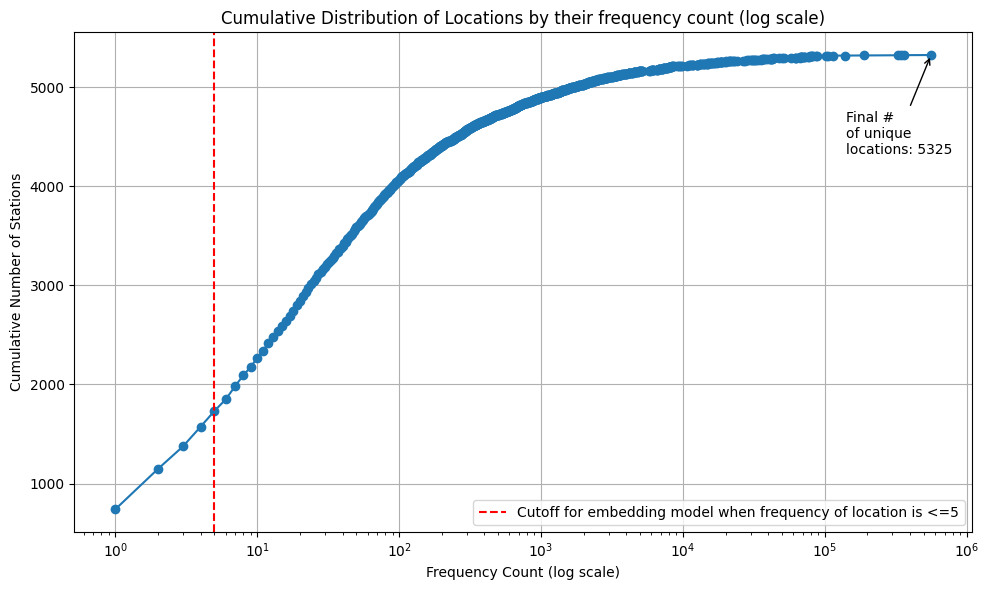

In [62]:
import matplotlib.pyplot as plt
count_distribution = df['Count'].value_counts().sort_index()

# Calculate cumulative distribution
cumulative_distribution = count_distribution.cumsum()

# Plotting
plt.figure(figsize=(10, 6))
plt.semilogx(cumulative_distribution.index, cumulative_distribution.values, marker='o', linestyle='-')
plt.xlabel('Frequency Count (log scale)')
plt.ylabel('Cumulative Number of Stations')
plt.title('Cumulative Distribution of Locations by their frequency count (log scale)')
plt.grid(True)

# Add highlight for x-value of 5
plt.axvline(x=5, color='red', linestyle='--', label='Cut-off for embedding model when frequency of location is <=5')

final_count = cumulative_distribution.values[-1]
plt.annotate(f'Final # \nof unique \nlocations: {final_count}', xy=(cumulative_distribution.index[-1], final_count),
             xytext=(cumulative_distribution.index[-1] / 4, final_count - 1000),
             arrowprops=dict(facecolor='black', arrowstyle='->'))



# Show legend
plt.legend()

plt.tight_layout()
plt.show()